In [85]:
from __future__ import division

import os
import itertools
import math
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import matplotlib.pylab as plt

from learning2learn.wrangle import synthesize_data
from learning2learn.wrangle import get_train_test_parameters
from learning2learn.wrangle import build_train_set_bits
from learning2learn.wrangle import build_test_trials_o1_bits 
from learning2learn.wrangle import build_test_trials_o2_bits
from learning2learn.util import train_test_split
from learning2learn.util import train_model
from learning2learn.util import evaluate_generalization
from learning2learn.util import get_hidden_representations
from learning2learn.util import similarity
from learning2learn.models import simple_mlp

In [156]:
paper_folder = '../../cogsci-paper/'

In [6]:
nb_categories = 30
nb_exemplars = 10
nb_test_trials = 1000
batch_size = min(32, int(np.floor(nb_categories*nb_exemplars/5)))

In [67]:
np.random.seed(0)
(shape_set_train, shape_set_test), \
(color_set_train, color_set_test), \
(texture_set_train, texture_set_test) = \
        get_train_test_parameters(images=False, nb_bits=20)
df_train, labels = synthesize_data(nb_categories, nb_exemplars)
labels = labels.values
ohe = OneHotEncoder(sparse=False)
Y_train = ohe.fit_transform(labels.reshape(-1, 1))

In [68]:
X_train = build_train_set_bits(df_train, shape_set_train, color_set_train, texture_set_train)

In [69]:
X_test_o1 = build_test_trials_o1_bits(
    df_train, shape_set_train, shape_set_test, color_set_train,
    color_set_test, texture_set_train, texture_set_test,
    nb_trials=nb_test_trials
)

In [70]:
X_test_o2 = build_test_trials_o2_bits(
    shape_set_test, color_set_test, texture_set_test,
    nb_trials=nb_test_trials
)

In [71]:
model = simple_mlp(nb_in=60, nb_classes=nb_categories)

In [72]:
weights_file = '../data/temp.h5'
if os.path.isfile(weights_file):
    os.remove(weights_file)
checkpoint = ModelCheckpoint(
    weights_file,
    monitor='loss',
    save_best_only=True,
    save_weights_only=True,
    period=2
)
train_model(
    model, X_train, Y_train, epochs=200,
    validation_data=None, batch_size=batch_size,
    checkpoint=checkpoint, burn_period=100
)
model.load_weights(weights_file)

Epoch 1/100
300/300 [==============================] - 0s 855us/step - loss: 3.8574 - acc: 0.0967
Epoch 2/100
300/300 [==============================] - 0s 49us/step - loss: 3.7311 - acc: 0.1167
Epoch 3/100
300/300 [==============================] - 0s 45us/step - loss: 3.6516 - acc: 0.1433
Epoch 4/100
300/300 [==============================] - 0s 47us/step - loss: 3.5795 - acc: 0.1567
Epoch 5/100
300/300 [==============================] - 0s 43us/step - loss: 3.5083 - acc: 0.1733
Epoch 6/100
300/300 [==============================] - 0s 41us/step - loss: 3.4397 - acc: 0.1700
Epoch 7/100
300/300 [==============================] - 0s 43us/step - loss: 3.3710 - acc: 0.2133
Epoch 8/100
300/300 [==============================] - 0s 40us/step - loss: 3.3035 - acc: 0.2367
Epoch 9/100
300/300 [==============================] - 0s 50us/step - loss: 3.2355 - acc: 0.2667
Epoch 10/100
300/300 [==============================] - 0s 43us/step - loss: 3.1676 - acc: 0.2800
Epoch 11/100
300/300 [======

300/300 [==============================] - 0s 43us/step - loss: 0.4679 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 49us/step - loss: 0.4624 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 44us/step - loss: 0.4552 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 46us/step - loss: 0.4487 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 46us/step - loss: 0.4425 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 43us/step - loss: 0.4368 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 45us/step - loss: 0.4297 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 0s 42us/step - loss: 0.4237 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 46us/step - loss: 0.4183 - acc: 1.0000
Epoch 93/100
300/300 [==============================] - 0s 44us/step - loss: 0.4128 - acc: 1.0000
Epoch 94/100
300/300 [===========

300/300 [==============================] - 0s 46us/step - loss: 0.1912 - acc: 1.0000
Epoch 68/100
300/300 [==============================] - 0s 72us/step - loss: 0.1903 - acc: 1.0000
Epoch 69/100
300/300 [==============================] - 0s 45us/step - loss: 0.1880 - acc: 1.0000
Epoch 70/100
300/300 [==============================] - 0s 77us/step - loss: 0.1876 - acc: 1.0000
Epoch 71/100
300/300 [==============================] - 0s 56us/step - loss: 0.1852 - acc: 1.0000
Epoch 72/100
300/300 [==============================] - 0s 79us/step - loss: 0.1838 - acc: 1.0000
Epoch 73/100
300/300 [==============================] - 0s 49us/step - loss: 0.1825 - acc: 1.0000
Epoch 74/100
300/300 [==============================] - 0s 77us/step - loss: 0.1809 - acc: 1.0000
Epoch 75/100
300/300 [==============================] - 0s 51us/step - loss: 0.1795 - acc: 1.0000
Epoch 76/100
300/300 [==============================] - 0s 69us/step - loss: 0.1780 - acc: 1.0000
Epoch 77/100
300/300 [===========

In [73]:
score = evaluate_generalization(
    model, X_test_o2, layer_num=-3,
    batch_size=128
)
print('Score O2: %0.4f' % score)

Score O2: 1.0000


In [74]:
np.random.seed(0)
s1, s2 = np.random.choice(range(len(shape_set_test)), 2, replace=False)
c1, c2 = np.random.choice(range(len(color_set_test)), 2, replace=False)
t1, t2 = np.random.choice(range(len(texture_set_test)), 2, replace=False)
shape1, shape2 = shape_set_test[s1], shape_set_test[s2]
color1, color2 = color_set_test[c1], color_set_test[c2]
texture1, texture2 = texture_set_test[t1], texture_set_test[t2]

In [48]:
def modify_feature(feature, nb_bits):
    assert type(nb_bits) == int and nb_bits >=0 and nb_bits <= 20
    np.random.seed(0)
    ix = np.random.permutation(range(20))
    feature_p = np.copy(feature)
    for i in ix[:nb_bits]:
        feature_p[i] = np.abs(feature[i] - 1)
    
    return feature_p

In [135]:
from sklearn.linear_model import LinearRegression

def plot_results(similarities, feature):
    # first compute the LR fit
    x_grid = np.arange(21).reshape(-1,1)
    lr = LinearRegression()
    lr.fit(x_grid, similarities.reshape(-1,1))
    y_grid = lr.predict(x_grid)
    
    assert feature in ['shape', 'color', 'texture']
    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.scatter(range(21), similarities)
    ax.plot(x_grid, y_grid, '--', color='grey', 
            label='OLS fit (coef: %0.4f)' % lr.coef_[0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0,1.1)
    ax.set_xlabel('# of %s bits flipped' % feature, fontsize=18)
    ax.set_ylabel('Model similarity', fontsize=18)
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_yticklabels(np.linspace(0,1,6), fontsize=15)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xticklabels(np.arange(0,21,5), fontsize=15)
    plt.legend(loc='lower right', fontsize=18)
    plt.suptitle('Bias strength vs. %s similarity' % feature, fontsize=18)
    plt.show()

# shape tests first, others_same=False

In [75]:
sample1 = np.hstack((shape1, color1, texture1))

In [76]:
sample2 = np.hstack((shape1, color2, texture2))
features = get_hidden_representations(
    model=model,
    X=np.vstack((sample1,sample2)),
    layer_num=-3,
    batch_size=2
)
print('similarity: %0.4f' % similarity(features[0], features[1]))

similarity: 0.9945


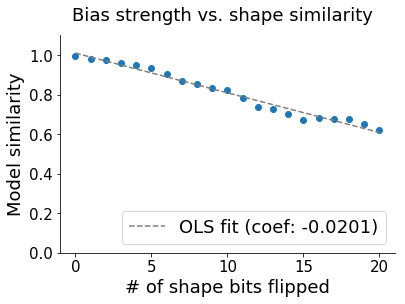

In [141]:
similarities = np.zeros(21)
for i in range(21):
    shape1_p = modify_feature(shape1, nb_bits=i)
    sample2 = np.hstack((shape1_p, color2, texture2))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
#     print('# flipped: %i' % i)
#     print('similarity: %0.4f\n' % similarities[i])
plot_results(similarities, 'shape')

# Now try shape again but with others_constant=True

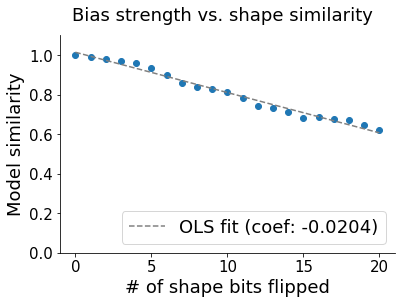

In [140]:
similarities = np.zeros(21)
for i in range(21):
    shape1_p = modify_feature(shape1, nb_bits=i)
    sample2 = np.hstack((shape1_p, color1, texture1))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'shape')

# Now try color, others_constant=False

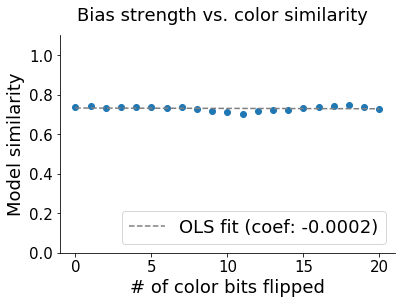

In [142]:
similarities = np.zeros(21)
for i in range(21):
    color1_p = modify_feature(color1, nb_bits=i)
    sample2 = np.hstack((shape2, color1_p, texture2))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'color')

# color, others_constant=True

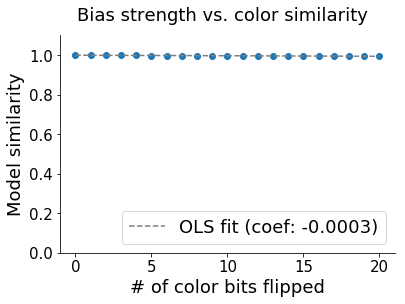

In [143]:
similarities = np.zeros(21)
for i in range(21):
    color1_p = modify_feature(color1, nb_bits=i)
    sample2 = np.hstack((shape1, color1_p, texture1))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'color')

# texture, others_constant=False

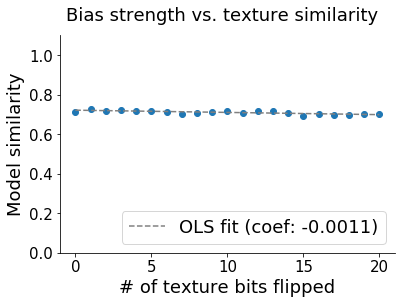

In [146]:
similarities = np.zeros(21)
for i in range(21):
    texture1_p = modify_feature(texture1, nb_bits=i)
    sample2 = np.hstack((shape2, color2, texture1_p))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'texture')

# texture, others_constant=True

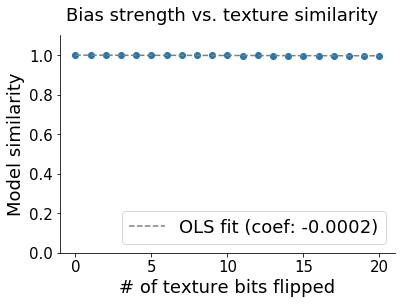

In [147]:
similarities = np.zeros(21)
for i in range(21):
    texture1_p = modify_feature(texture1, nb_bits=i)
    sample2 = np.hstack((shape1, color1, texture1_p))
    features = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2)),
        layer_num=-3,
        batch_size=2
    )
    similarities[i] = similarity(features[0], features[1])
plot_results(similarities, 'texture')

In [ ]:
# Place all 3 results for others_constant=False on the same graph

In [148]:
similarities_shape = np.zeros(21)
similarities_color = np.zeros(21)
similarities_texture = np.zeros(21)
for i in range(21):
    shape1_p = modify_feature(shape1, nb_bits=i)
    color1_p = modify_feature(color1, nb_bits=i)
    texture1_p = modify_feature(texture1, nb_bits=i)
    sample2_shape = np.hstack((shape1_p, color2, texture2))
    sample2_color = np.hstack((shape2, color1_p, texture2))
    sample2_texture = np.hstack((shape2, color2, texture1_p))
    features_shape = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2_shape)),
        layer_num=-3,
        batch_size=2
    )
    features_color = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2_color)),
        layer_num=-3,
        batch_size=2
    )
    features_texture = get_hidden_representations(
        model=model,
        X=np.vstack((sample1,sample2_texture)),
        layer_num=-3,
        batch_size=2
    )
    similarities_shape[i] = similarity(features_shape[0], features_shape[1])
    similarities_color[i] = similarity(features_color[0], features_color[1])
    similarities_texture[i] = similarity(features_texture[0], features_texture[1])

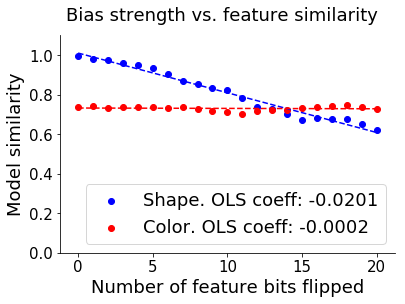

In [157]:
# first compute the LR fit
x_grid = np.arange(21).reshape(-1,1)
lr_shape = LinearRegression()
lr_color = LinearRegression()
lr_texture = LinearRegression()
lr_shape.fit(x_grid, similarities_shape.reshape(-1,1))
lr_color.fit(x_grid, similarities_color.reshape(-1,1))
lr_texture.fit(x_grid, similarities_texture.reshape(-1,1))
y_grid_shape = lr_shape.predict(x_grid)
y_grid_color = lr_color.predict(x_grid)
y_grid_texture = lr_texture.predict(x_grid)
    
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(range(21), similarities_shape, color='blue', 
           label='Shape. OLS coeff: %0.4f' % lr_shape.coef_[0])
ax.scatter(range(21), similarities_color, color='red', 
           label='Color. OLS coeff: %0.4f' % lr_color.coef_[0])
# ax.scatter(range(21), similarities_texture, color='green', 
#            label='Texture. OLS coeff: %0.4f' % lr_texture.coef_[0])
ax.plot(x_grid, y_grid_shape, '--', color='blue')
ax.plot(x_grid, y_grid_color, '--', color='red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,1.1)
ax.set_xlabel('Number of feature bits flipped', fontsize=18)
ax.set_ylabel('Model similarity', fontsize=18)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(np.linspace(0,1,6), fontsize=15)
ax.set_xticks(np.arange(0,21,5))
ax.set_xticklabels(np.arange(0,21,5), fontsize=15)
plt.legend(loc='lower right', fontsize=18)
plt.suptitle('Bias strength vs. feature similarity', fontsize=18)
#plt.show()
plt.savefig(
    os.path.join(paper_folder, 'figures/mlp_parametric.pdf'),
    format='pdf',
    bbox_inches='tight'
)